<a href="https://colab.research.google.com/github/martinfernandoortiz/geoestadistica_unlp/blob/main/Interpolacion_espacial_clase_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# *Guia de la pràctica 3 - Parte II*

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon
import sklearn
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from joblib import dump, load

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Definimos las funciones que vamos a utilizar:
 - Metodo de inversa distancia (IDW)
 - K nearest neigbors (KNN)
 - Funciones para graficar grillas

In [2]:
def distance_matrix(x0, y0, x1, y1):
    """ Make a distance matrix between pairwise observations.
    Note: from <http://stackoverflow.com/questions/1871536>
    """

    obs = np.vstack((x0, y0)).T
    interp = np.vstack((x1, y1)).T

    d0 = np.subtract.outer(obs[:,0], interp[:,0])
    d1 = np.subtract.outer(obs[:,1], interp[:,1])

    # calculate hypotenuse
    return np.hypot(d0, d1)

def simple_idw(x, y, z, xi, yi, power=1):
    """ Simple inverse distance weighted (IDW) interpolation
    Weights are proportional to the inverse of the distance, so as the distance
    increases, the weights decrease rapidly.
    The rate at which the weights decrease is dependent on the value of power.
    As power increases, the weights for distant points decrease rapidly.
    """

    dist = distance_matrix(x,y, xi,yi)

    # In IDW, weights are 1 / distance
    weights = 1.0/(dist+1e-12)**power

    # Make weights sum to one
    weights /= weights.sum(axis=0)

    # Multiply the weights for each interpolated point by all observed Z-values
    return np.dot(weights.T, z)


def knn(df_coordenadas, model):
    """ K-NN
     Inputs:
     - dataframe con las coordenadas. LA lectura de las mismas
 por parte del modelo tienen la forma [[x1,y1], [x2, y2],...[xn,yn]]
     - modelo predictivo

     Outputs: predicciones del modelo a partir del modelo (valor de zi),
          a partir d elas coordenadas de cada punto de la grilla
    """
    predictions_KNN = model.predict(df_coordenadas.values)
    return predictions_KNN

def plot(x,y,z, grid, Isocontornos = None):
    """ Plot the input points and the result """
    extent = (x.min(), x.max(), y.min(), y.max() )
    plt.figure(figsize=(15,10))
    plt.imshow(grid, extent=extent, cmap='rainbow', interpolation='gaussian')

    if Isocontornos != None:
        plt.contour(grid, extent=extent, levels=Isocontornos, linewidths=1, colors='gray')
    plt.scatter(x, y, c=z, cmap='rainbow', edgecolors='black', linewidths=0.5, alpha=0.7,s=20)
    plt.colorbar()



def plot(x, y, z, grid, Isocontornos=None, country_boundaries=None):
    """ Plot the input points, result, and country boundaries """
    extent = (x.min(), x.max(), y.min(), y.max())
    plt.figure(figsize=(15, 10))

    # Mostrar la grilla interpolada como una imagen
    plt.imshow(grid, extent=extent, cmap='rainbow', interpolation='gaussian',aspect='auto')

    # Agregar isocontornos si se proporcionan
    if Isocontornos is not None:
        # Personalizar la apariencia de los isocontornos
        plt.contour(grid, extent=extent, levels=Isocontornos, linewidths=1, colors='gray')

    # Mostrar los límites del país como referencia
    if country_boundaries is not None:
        #country_boundaries.plot(ax=plt.gca(), edgecolor='black', linewidth=1)
        country_boundaries.boundary.plot(ax=plt.gca(), color='black', linewidth=1, linestyle='dashed')
    # Mostrar los puntos de entrada en el gráfico con bordes más finos, contorno más transparente y puntos más pequeños
    plt.scatter(x, y, c=z, cmap='rainbow', edgecolors='black', linewidths=0.5, alpha=0.7, s=20)

    # Agregar una barra de color para la escala de colores
    plt.colorbar()

***
# *Apertura de  datos*

***

In [3]:
# 1- Abrir la tabla filtrada (resultado final de la Pràctica 1)

df = pd.read_csv('/content/drive/My Drive/datasets_colab/smn_coord.csv')


In [4]:
# Carga de país

# Cargar los límites del país desde un archivo GeoJSON (cambia la ruta al archivo correspondiente)
country_boundaries = gpd.read_file('/content/drive/My Drive/datasets_colab/pais.gpkg')

In [5]:
#######################
#
#   Retocamos algunos tipo de datos para todos sean float (numeros reales)
#
########################################################3

In [6]:
#######################################
#
#   reemplaza lo que aparece como "S/D" en "cero"
#
###############################################3

df.replace("S/D", 0, inplace = True)
df.replace(np.nan, 0, inplace = True)


In [7]:
df.columns

Index(['fid', '...1', 'Estacion', 'mes', 'lat', 'long', 'Altura_(m)', 'Numero',
       'Temperatura_(C)', 'Temperatura_maxima_(C)', 'Temperatura_minima_(C)',
       'Humedad_relativa_(%)', 'Velocidad_del_Viento_(km/h)',
       'Nubosidad_total_(octavos)', 'Precipitacion_(mm)',
       'Frecuencia_dias_Precipitacion_>0.1_mm'],
      dtype='object')

In [8]:
# transforma todas las columnas, menos 'Unnamed: 0', 'Unnamed: 0.1', 'Estacion', 'mes'
#  en columnas con numeros reales

for col in df.drop(['fid', '...1', 'Estacion', 'mes'], axis = 1):
    df[col] = pd.to_numeric(df[col])

In [9]:
df_filtered = df[['lat', 'long', 'Temperatura_(C)']].dropna()
#df_sin_nan = df['lat','long','Temperatura_(C)'].dropna()


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 840 entries, 0 to 839
Data columns (total 16 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   fid                                    840 non-null    int64  
 1   ...1                                   840 non-null    int64  
 2   Estacion                               840 non-null    object 
 3   mes                                    840 non-null    object 
 4   lat                                    840 non-null    float64
 5   long                                   840 non-null    float64
 6   Altura_(m)                             840 non-null    int64  
 7   Numero                                 840 non-null    int64  
 8   Temperatura_(C)                        840 non-null    float64
 9   Temperatura_maxima_(C)                 840 non-null    float64
 10  Temperatura_minima_(C)                 840 non-null    float64
 11  Humeda

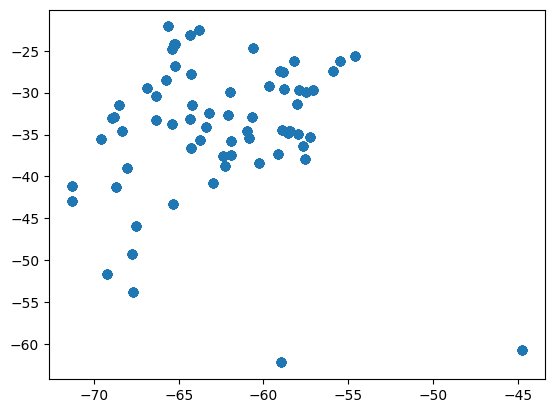

In [11]:
#######################
#
#   Ejemplo: datos de Temperatura media
#
###########################################
y = df_filtered.lat.values
x = df_filtered.long.values
z = df_filtered['Temperatura_(C)'].values
plt.scatter(x,y)

***
# *Armado de la grilla*
***

In [12]:
# size of the grid to interpolate
nx, ny = 100, 100

# generate two arrays of evenly space data between ends of
#  previous arrays
xi = np.linspace(x.min(), x.max(), nx)
yi = np.linspace(y.max(), y.min(), ny)

# generate grid
xi, yi = np.meshgrid(xi, yi)

# colapse grid into 1D
xi, yi = xi.flatten(), yi.flatten()

***
# *Aplicaciòn del mètodo IDW*
***

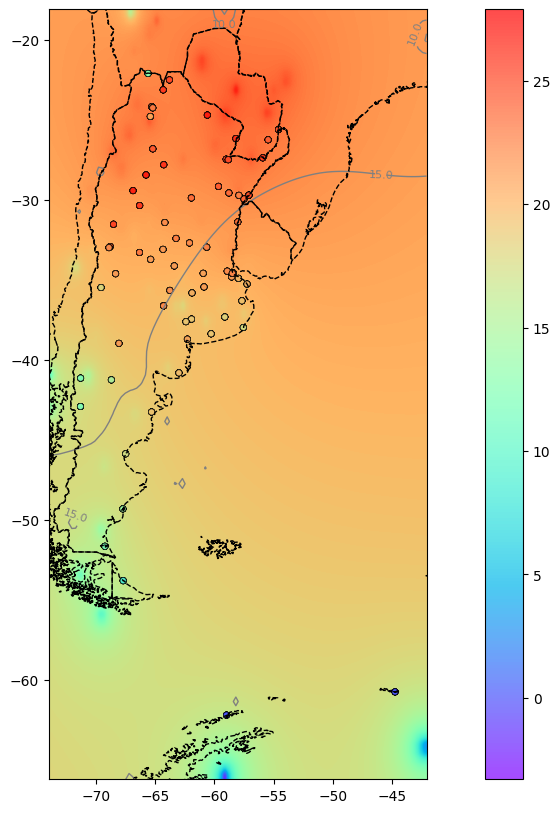

In [18]:

def plot_with_country(x, y, z, grid, Isocontornos=None, country_boundaries=None, margin_scale=0.1):
    """ Plot the input points, result, and country boundaries with a specified margin """

    # Obtener los límites del bounding box de los puntos
    x_min, x_max = x.min(), x.max()
    y_min, y_max = y.min(), y.max()

    # Calcular el rango del bounding box de los puntos
    x_range = x_max - x_min
    y_range = y_max - y_min

    # Calcular los límites ajustados con un margen del 10%
    x_min_adjusted = x_min - margin_scale * x_range
    x_max_adjusted = x_max + margin_scale * x_range
    y_min_adjusted = y_min - margin_scale * y_range
    y_max_adjusted = y_max + margin_scale * y_range

    plt.figure(figsize=(15, 10))

    # Mostrar la grilla interpolada como una imagen
    plt.imshow(grid, extent=(x_min_adjusted, x_max_adjusted, y_min_adjusted, y_max_adjusted), cmap='rainbow', interpolation='gaussian', aspect='auto')

    # Agregar isocontornos si se proporcionan
    if Isocontornos is not None:
        # Personalizar la apariencia de los isocontornos
        contours = plt.contour(grid, extent=(x_min_adjusted, x_max_adjusted, y_min_adjusted, y_max_adjusted), levels=Isocontornos, linewidths=1, colors='gray')
        # Agregar etiquetas a los isocontornos
        plt.clabel(contours, inline=True, fontsize=8, fmt='%1.1f')

    # Mostrar los límites del país como referencia sin relleno
    if country_boundaries is not None:
        country_boundaries.boundary.plot(ax=plt.gca(), color='black', linewidth=1, linestyle='dashed')

    # Mostrar los puntos de entrada en el gráfico con bordes más finos, contorno más transparente y puntos más pequeños
    plt.scatter(x, y, c=z, cmap='rainbow', edgecolors='black', linewidths=0.5, alpha=0.7, s=20)

    # Agregar una barra de color para la escala de colores
    plt.colorbar()

    # Ajustar los límites del eje según el bounding box ajustado con margen
    plt.xlim(x_min_adjusted, x_max_adjusted)
    plt.ylim(y_min_adjusted, y_max_adjusted)

# Ejemplo de uso
exponente = 1
grid1 = simple_idw(x,y,z,xi,yi, power = exponente )
grid1 = grid1.reshape((ny, nx))
plot_with_country(x, y, z, grid1, Isocontornos=[-10,-5,0,5, 10,15, 20,25,30, 35], country_boundaries=country_boundaries, margin_scale=0.1)
plt.show()

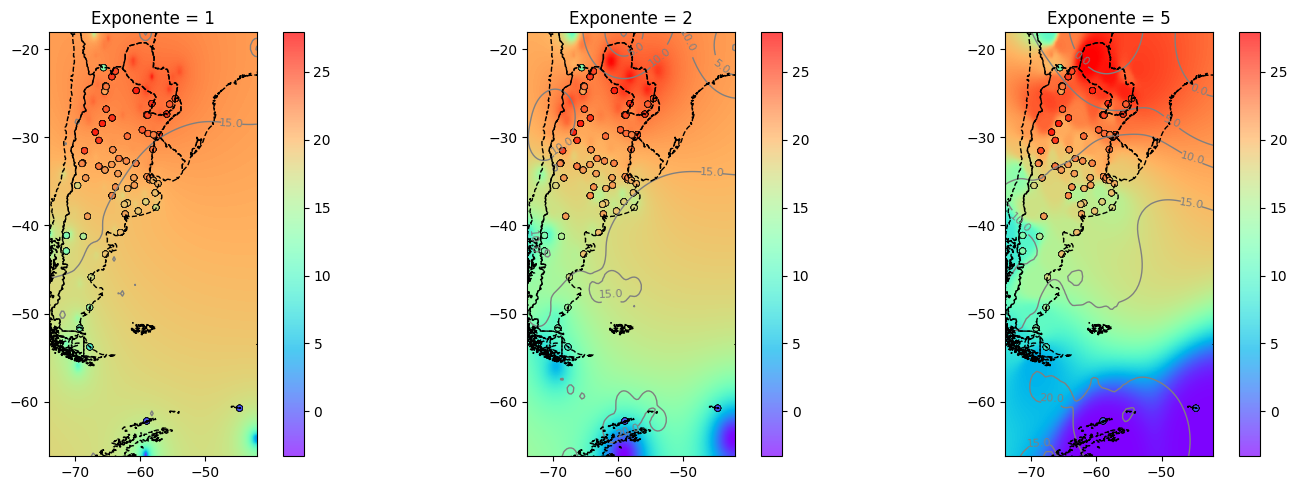

In [20]:

# Definir los diferentes valores de exponente
exponentes = [1, 2, 5]

# Crear subgráficos en una fila
plt.figure(figsize=(15, 5))

for i, exponente in enumerate(exponentes, 1):
    # Calcular la grilla interpolada
    grid = simple_idw(x, y, z, xi, yi, power=exponente)
    grid = grid.reshape((ny, nx))

    # Crear un subplot en la posición i
    plt.subplot(1, len(exponentes), i)

    # Calcular los límites ajustados con un margen del 10%
    x_min, x_max = x.min(), x.max()
    y_min, y_max = y.min(), y.max()
    x_range = x_max - x_min
    y_range = y_max - y_min
    margin_scale = 0.1
    x_min_adjusted = x_min - margin_scale * x_range
    x_max_adjusted = x_max + margin_scale * x_range
    y_min_adjusted = y_min - margin_scale * y_range
    y_max_adjusted = y_max + margin_scale * y_range

    # Mostrar la grilla interpolada como una imagen
    plt.imshow(grid, extent=(x_min_adjusted, x_max_adjusted, y_min_adjusted, y_max_adjusted),
               cmap='rainbow', interpolation='gaussian', aspect='auto')

    # Agregar isocontornos si se proporcionan
    Isocontornos = [-10, -5, 0, 5, 10, 15, 20, 25, 30, 35]
    if Isocontornos is not None:
        # Personalizar la apariencia de los isocontornos
        contours = plt.contour(grid, extent=(x_min_adjusted, x_max_adjusted, y_min_adjusted, y_max_adjusted),
                               levels=Isocontornos, linewidths=1, colors='gray')
        # Agregar etiquetas a los isocontornos
        plt.clabel(contours, inline=True, fontsize=8, fmt='%1.1f')

    # Mostrar los límites del país como referencia sin relleno
    if country_boundaries is not None:
        country_boundaries.boundary.plot(ax=plt.gca(), color='black', linewidth=1, linestyle='dashed')

    # Mostrar los puntos de entrada en el gráfico con bordes más finos, contorno más transparente y puntos más pequeños
    plt.scatter(x, y, c=z, cmap='rainbow', edgecolors='black', linewidths=0.5, alpha=0.7, s=20)

    # Agregar una barra de color para la escala de colores
    plt.colorbar()

    # Ajustar los límites del eje según el bounding box ajustado con margen
    plt.xlim(x_min_adjusted, x_max_adjusted)
    plt.ylim(y_min_adjusted, y_max_adjusted)

    # Agregar un título que incluya el valor actual de exponente
    plt.title(f'Exponente = {exponente}')

# Ajustar el diseño para evitar superposiciones
plt.tight_layout()

# Mostrar los gráficos
plt.show()

***
# *Aplicaciòn del mètodo KNN*
***

Vamos a proponer un modelo de predicciòn de valores

In [21]:
############################################
#
#     Tomamos la "Temperatura# como ejemplo
#
################################################

coords_temp = df_filtered[['long','lat']].values
value_temp = df_filtered['Temperatura_(C)'].values

############################################
#
#     Separamos en train y test los datos
#
################################################
coords_temp_train, coords_temp_test, value_temp_train, value_temp_test = train_test_split(coords_temp, value_temp, test_size = 0.30, random_state = 32024242)


############################################
#
#  - Definimos la cantidsd de vecinos
#  - Inicializamos el modelo KNN (del tipo regresiòn)
#
################################################
neighbors = 20


knn_regressor = KNeighborsRegressor(n_neighbors = neighbors,
                                    weights = "distance")


############################################
#
#  - Ajustamos el modelo con los datos de entrenamiento "train"
#
#
################################################
knn_regressor.fit(coords_temp_train, value_temp_train)

KNeighborsRegressor(n_neighbors=20, weights='distance')

1. Evaluacion de modelo
2. Prediccion del modelo

In [22]:
# Generate out-of-sample R^2
out_r_squared_knn = knn_regressor.score(coords_temp_test, value_temp_test)
print("KNN out-of-sample r-squared: {}".format(round(out_r_squared_knn, 2)))


KNN out-of-sample r-squared: 0.34
Mean Squared Error: 29.857041610631125


- knn_regressor.score(coords_temp_test, value_temp_test): Este método score es proporcionado por los modelos de scikit-learn y se utiliza para evaluar el rendimiento del modelo. En el caso de KNeighborsRegressor, este método devuelve el coeficiente de determinación (R^2) de la predicción. R^2 es una medida estadística que indica qué tan bien se ajustan las predicciones del modelo a los valores reales.

- coords_temp_test: Son las coordenadas de los datos de prueba. Estos son los puntos en el espacio para los cuales queremos predecir los valores objetivo.

- value_temp_test: Son las etiquetas reales (valores objetivo) asociadas a cada punto en coords_temp_test. Estos son los valores reales que el modelo intentará predecir.

- out_r_squared_knn: Es la variable que almacena el resultado del cálculo del coeficiente de determinación (R^2) para el modelo KNN en el conjunto de datos de prueba. Un valor más alto de R^2 (cercano a 1) indica un mejor ajuste del modelo a los datos de prueba.

En resumen, out_r_squared_knn contiene la medida de rendimiento del modelo KNN en los datos de prueba, evaluada mediante el coeficiente de determinación (R^2). Un R^2 cercano a 1 sugiere que el modelo está haciendo buenas predicciones.

El coeficiente de determinación, comúnmente denotado como R^2, es una medida que indica cuánta varianza en la variable dependiente (la variable que estás tratando de predecir) es explicada por el modelo. R^2 puede tener valores entre 0 y 1, y su interpretación es la siguiente:

- **R^2 cercano a 1:** Indica que una gran proporción de la variabilidad en la variable dependiente está siendo explicada por el modelo. En otras palabras, el modelo se ajusta bien a los datos y hace buenas predicciones.

- **R^2 cercano a 0:** Indica que el modelo no está explicando mucha variabilidad en la variable dependiente. Puede ser que el modelo sea insuficiente o que la variable dependiente no esté fuertemente relacionada con las variables independientes.

- **R^2 negativo:** Esto podría ocurrir cuando el modelo es muy pobre y hace predicciones peores que simplemente usar la media de la variable dependiente.

En resumen, cuanto más cercano a 1 sea el valor de R^2, mejor se ajusta el modelo a los datos y mejor es su capacidad predictiva. Sin embargo, R^2 no es la única métrica de evaluación y debe considerarse junto con otras métricas relevantes dependiendo del contexto del problema. Por ejemplo, también podrías examinar el error cuadrático medio (MSE) u otras métricas específicas del problema.

El Mean Squared Error (MSE) es una métrica de evaluación comúnmente utilizada para evaluar la precisión de un modelo de regresión. MSE mide el promedio de los cuadrados de los errores entre las predicciones del modelo y los valores reales. En tu caso, has calculado un MSE de aproximadamente 29.86.

La interpretación del MSE puede variar según el dominio del problema, pero en términos generales:

- MSE más bajo: Indica que las predicciones del modelo están más cerca de los valores reales. En este sentido, un MSE más bajo es mejor.

- MSE más alto: Indica que las predicciones del modelo están más lejos de los valores reales. Un MSE más alto sugiere un peor ajuste del modelo a los datos.

En tu caso, un MSE de 29.86 significa que, en promedio, los cuadrados de los errores entre las predicciones del modelo KNN y los valores reales son alrededor de 29.86. En general, es útil comparar el MSE con la escala de tus datos para obtener una comprensión más intuitiva del error. Por ejemplo, si tus datos tienen un rango de 0 a 100, un MSE de 29.86 podría indicar un error considerable, pero si tus datos tienen un rango de 0 a 1000, el mismo MSE podría ser considerado aceptable.

En resumen, buscas minimizar el MSE, ya que un valor más bajo indica una mejor calidad de ajuste del modelo a los datos de prueba.

In [28]:

#knn_regressor.(coords_temp_test, value_temp_test)
knn_regressor.
###################################
#
#    Mean_square_error
#
################################################

pred_y = knn_regressor.predict(coords_temp_test)
y = value_temp_test

mse = mean_squared_error(y, pred_y)
print("Mean Squared Error:",mse)


# Predict values for testing dataset
values_temp_test_predict_knn = knn_regressor.predict(coords_temp_test)

Mean Squared Error: 29.839829066539416


In [29]:
predicciones = knn_regressor.predict(coords_temp_test)
residuos = value_temp_test - predicciones



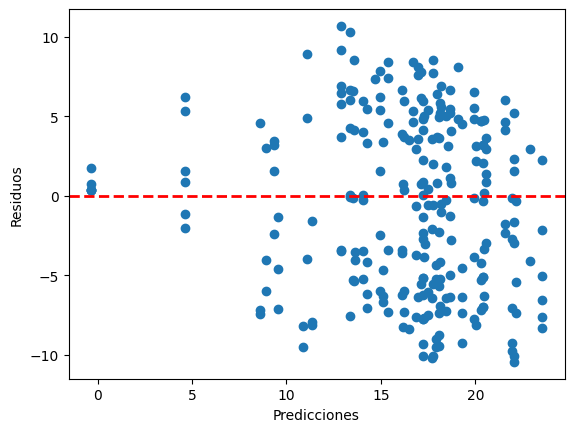

In [30]:
plt.scatter(predicciones, residuos)
plt.xlabel('Predicciones')
plt.ylabel('Residuos')
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.show()

In [ ]:
Evalúa la Distribución de Residuos:
Una línea recta en el gráfico QQ indica una distribución normal.

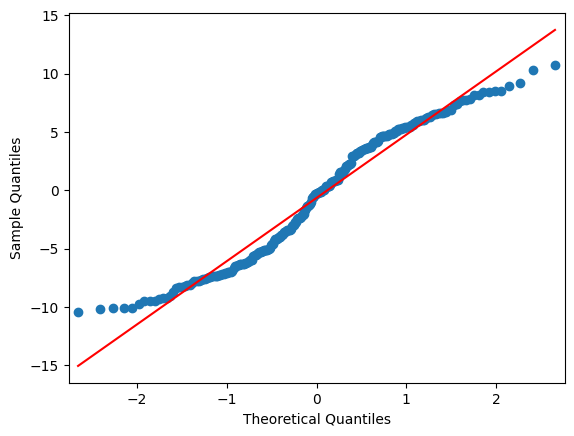

In [31]:
import statsmodels.api as sm
sm.qqplot(residuos, line='s')
plt.show()

Validación Cruzada:

La validación cruzada es un enfoque para evaluar el rendimiento del modelo en múltiples conjuntos de datos. Uno de los métodos más comunes es el "k-fold cross-validation". Aquí hay un ejemplo de cómo realizarlo:

In [32]:
from sklearn.model_selection import cross_val_score, KFold

# Define el número de 'folds' (particiones) para la validación cruzada
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Realiza la validación cruzada y obtén las puntuaciones de cada fold
puntuaciones = cross_val_score(knn_regressor, coords_temp_train, value_temp_train, cv=kf, scoring='neg_mean_squared_error')

# Convierte las puntuaciones negativas a positivas
mse_scores = -puntuaciones

# Imprime las puntuaciones de MSE para cada fold
print("Puntuaciones de MSE para cada fold:", mse_scores)

# Calcula y muestra el MSE promedio
print("MSE promedio:", np.mean(mse_scores))

Puntuaciones de MSE para cada fold: [26.21775864 28.47939418 30.97639669 31.60375441 33.33476107]
MSE promedio: 30.122412998812855


  Un MSE más bajo indica que las predicciones del modelo son más cercanas a los valores reales. Por lo tanto, en tu caso, un MSE promedio de aproximadamente 30.12 podría interpretarse como un nivel de error moderado.
  Si las puntuaciones de MSE varían significativamente entre los folds, podría indicar que el rendimiento del modelo varía en diferentes subconjuntos de datos. Esto podría sugerir cierta sensibilidad del modelo a la partición específica de los datos.

En resumen, la interpretación específica depende del contexto y de las características específicas de tu problema. En general, buscas un MSE más bajo, pero también es importante tener en cuenta la variabilidad entre folds para evaluar la robustez del modelo.

In [23]:
len(xi)
len(yi)

10000

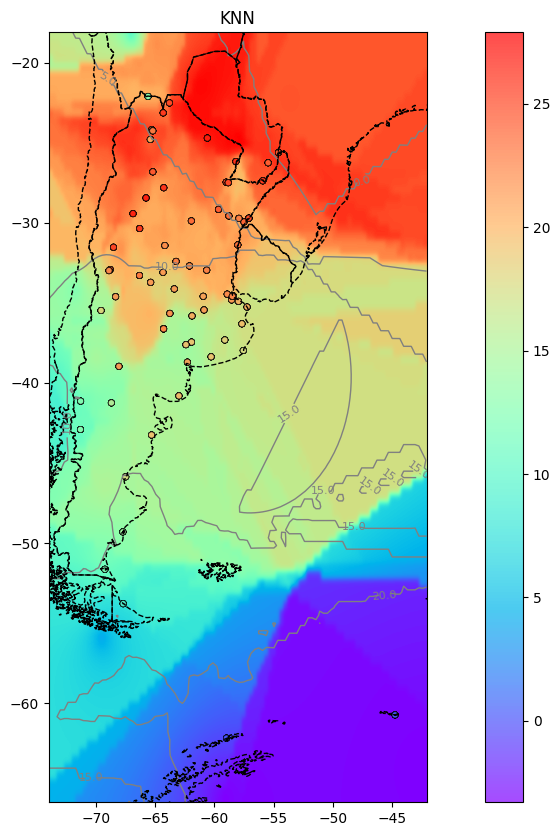

In [24]:
################################################
#
#    - Armado de un dataframe adecuando para introducir
#       las coordenadas de la forma adecuada para el modelo KNN
#
#    - Llamado a la funcion del metodo de interpolacion KNN
#
#   -  Llamaod a la funcion gráfica
#
#########################################################3
dfC= pd.DataFrame(columns = ['x','y'])
dfC['x'] = xi
dfC['y'] = yi


grid1 = knn(dfC, knn_regressor)
grid1 = grid1.reshape((ny, nx))


y = df_filtered.lat.values
x = df_filtered.long.values
z = df_filtered['Temperatura_(C)'].values

plot_with_country(x, y, z, grid1, Isocontornos=[-10,-5,0,5, 10,15, 20,25,30, 35], country_boundaries=country_boundaries, margin_scale=0.1)

#plot(x,y,z, grid1, contornos)
plt.title('KNN')
plt.show()


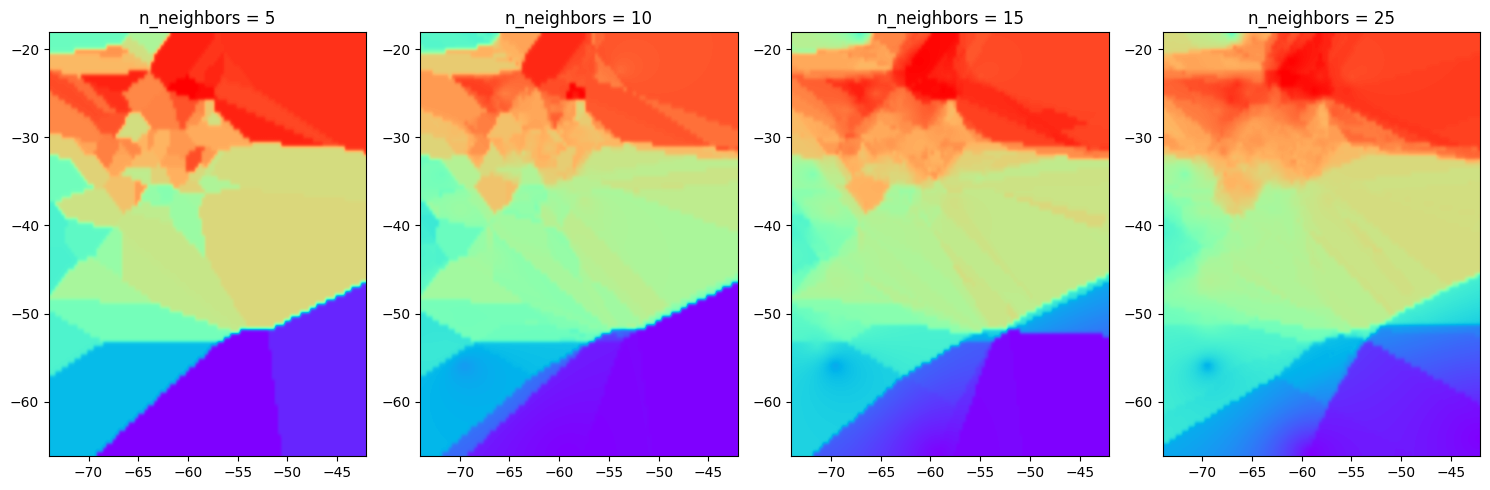

In [35]:
# Itera sobre diferentes valores de n_neighbors
neighbors_values = [5, 10, 15,25]  # Puedes ajustar estos valores según sea necesario

# Crea subgráficos en una fila
fig, axs = plt.subplots(1, len(neighbors_values), figsize=(15, 5))

for i, neighbors in enumerate(neighbors_values, 1):
    # Inicializa el modelo KNN
    knn_regressor = KNeighborsRegressor(n_neighbors=neighbors, weights="distance")

    # Ajusta el modelo con los datos de entrenamiento
    knn_regressor.fit(coords_temp_train, value_temp_train)

    # Genera el grid interpolado con el modelo KNN
    grid1 = knn(dfC, knn_regressor)
    grid1 = grid1.reshape((ny, nx))

    # Grafica con la función plot_with_country
    axs[i - 1].imshow(grid1, extent=(x_min_adjusted, x_max_adjusted, y_min_adjusted, y_max_adjusted),
                      cmap='rainbow', interpolation='gaussian', aspect='auto')
    axs[i - 1].set_title(f'n_neighbors = {neighbors}')

# Ajusta el diseño para evitar superposiciones
plt.tight_layout()

# Muestra los gráficos
plt.show()

In [52]:
def plot_with_country_knn(x, y, z, grid, Isocontornos=None, country_boundaries=None, margin_scale=0.1, ax=None):
    """ Plot the input points, result, and country boundaries with a specified margin """

    # Obtener los límites del bounding box de los puntos
    x_min, x_max = x.min(), x.max()
    y_min, y_max = y.min(), y.max()

    # Calcular el rango del bounding box de los puntos
    x_range = x_max - x_min
    y_range = y_max - y_min

    # Calcular los límites ajustados con un margen del 10%
    x_min_adjusted = x_min - margin_scale * x_range
    x_max_adjusted = x_max + margin_scale * x_range
    y_min_adjusted = y_min - margin_scale * y_range
    y_max_adjusted = y_max + margin_scale * y_range

    # Mostrar la grilla interpolada como una imagen en el eje especificado (ax)
    im = ax.imshow(grid, extent=(x_min_adjusted, x_max_adjusted, y_min_adjusted, y_max_adjusted), cmap='rainbow', interpolation='gaussian', aspect='auto')

    # Agregar isocontornos si se proporcionan en el eje especificado (ax)
    if Isocontornos is not None:
        contours = ax.contour(grid, extent=(x_min_adjusted, x_max_adjusted, y_min_adjusted, y_max_adjusted), levels=Isocontornos, linewidths=1, colors='gray')
        ax.clabel(contours, inline=True, fontsize=8, fmt='%1.1f')

    # Mostrar los límites del país como referencia sin relleno
    if country_boundaries is not None:
        country_boundaries.boundary.plot(ax=ax, color='black', linewidth=1, linestyle='dashed')

    # Mostrar los puntos de entrada en el gráfico con bordes más finos, contorno más transparente y puntos más pequeños
    scatter = ax.scatter(x, y, c=z, cmap='rainbow', edgecolors='black', linewidths=0.5, alpha=0.7, s=20)

    # Agregar una barra de color para la escala de colores
    plt.colorbar(scatter, ax=ax)

    # Ajustar los límites del eje según el bounding box ajustado con margen
    ax.set_xlim(x_min_adjusted, x_max_adjusted)
    ax.set_ylim(y_min_adjusted, y_max_adjusted)

    # Quitar etiquetas de los ejes x e y
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')

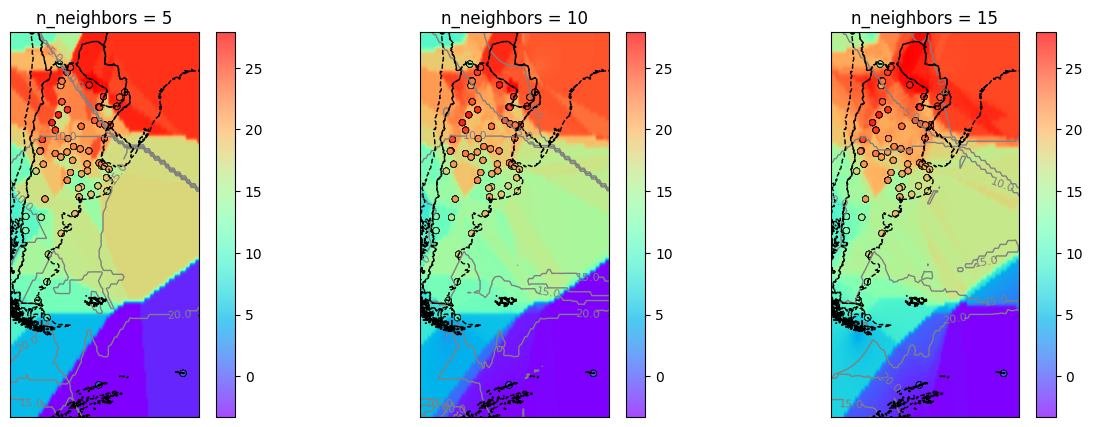

In [53]:
neighbors_values = [5, 10, 15]  # Puedes ajustar estos valores según sea necesario
x_knn = df_filtered['long'].values
y_knn = df_filtered['lat'].values
z_knn = df_filtered['Temperatura_(C)'].values

# Crea subgráficos en una fila
fig, axs = plt.subplots(1, len(neighbors_values), figsize=(15, 5))

# Define los isocontornos que se mostrarán en todos los gráficos
isocontornos_comunes = [-10, -5, 0, 5, 10, 15, 20, 25, 30, 35]

for i, neighbors in enumerate(neighbors_values, 1):
    # Inicializa el modelo KNN
    knn_regressor = KNeighborsRegressor(n_neighbors=neighbors, weights="distance")

    # Ajusta el modelo con los datos de entrenamiento
    knn_regressor.fit(coords_temp_train, value_temp_train)

    # Genera el grid interpolado con el modelo KNN
    grid1 = knn(dfC, knn_regressor)
    grid1 = grid1.reshape((ny, nx))

    # Utiliza la misma función para ambos tipos de gráficos
    plot_with_country_knn(x_knn, y_knn, z_knn, grid1, Isocontornos=isocontornos_comunes,
                           country_boundaries=country_boundaries, margin_scale=0.1, ax=axs[i - 1])

    axs[i - 1].set_title(f'n_neighbors = {neighbors}')

***
# Guardado del modelo
***

In [ ]:
dump("nombre_interno_del_modelo, 'filename.joblib')

***
# Si quiero abrir el modelo
***

In [ ]:
model = load('filename.joblib')